# Import Libraries

In [2]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import joblib
import random

# Load Images

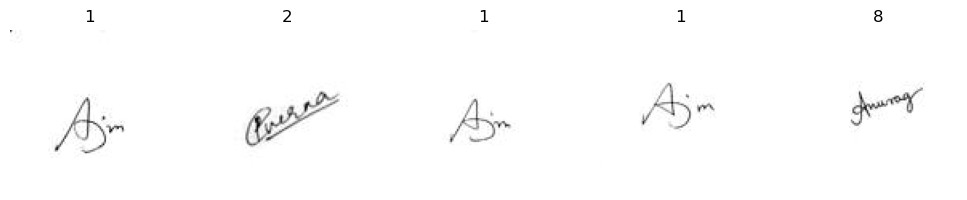

In [3]:
# Load images from folder and create labels
def load_images_from_folder(folder, label, target_size=(100, 100)):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith('.jpg'):  # Ensure processing only JPG files
            img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE) # Convert image to grayscale
            if img is not None:
                # Resize the image to 100x100 pixels
                resized_img = cv2.resize(img, target_size)
                images.append(resized_img)
                labels.append(label)
    return images, labels

folder_path = 'Signatures_cropped'
all_images = []
all_labels = []
for signature_folder in os.listdir(folder_path):
    signature_path = os.path.join(folder_path, signature_folder)
    signature_images, signature_labels = load_images_from_folder(signature_path, signature_folder)
    all_images.extend(signature_images)
    all_labels.extend(signature_labels)

# Function to display images
def display_images(image_list, title_list, cols=5):
    rows = len(image_list) // cols + int(len(image_list) % cols > 0)
    plt.figure(figsize=(cols * 2, rows * 2))
    for i, (image, title) in enumerate(zip(image_list, title_list)):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Selecting 5 random images and their labels
selected_indices = random.sample(range(len(all_images)), 5)
selected_images = [all_images[i] for i in selected_indices]
selected_labels = [all_labels[i] for i in selected_indices]

# Displaying 5 random images
display_images(selected_images, selected_labels)

# Augment Images

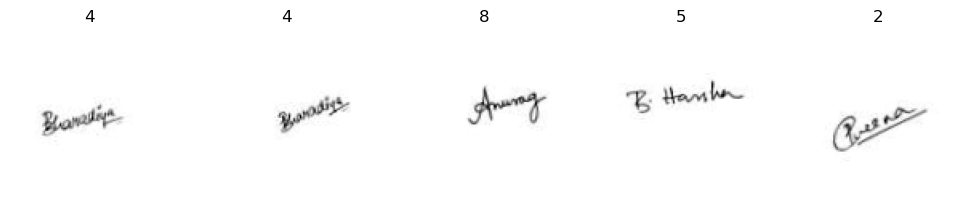

In [4]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)


images_array = np.array(all_images)
images_array = images_array.reshape((-1, ) + images_array.shape[1:] + (1,))

augmented_images = []
for img in images_array:
    img = img.reshape((1,) + img.shape)
    for _ in range(5):
        augmented_image = next(datagen.flow(img, batch_size=1))
        augmented_images.append(augmented_image[0].squeeze())

# Combine original and augmented images
combined_images = all_images + augmented_images

# Duplicate labels for augmented images
N = 5
augmented_labels = []
for label in all_labels:
    augmented_labels.extend([label] * N)

combined_labels = all_labels + augmented_labels

# Selecting 5 random augmented images and their labels
selected_augmented_indices = random.sample(range(len(augmented_images)), 5)
selected_augmented_images = [augmented_images[i] for i in selected_augmented_indices]
selected_augmented_labels = [augmented_labels[i] for i in selected_augmented_indices]

# Displaying 5 random augmented images
display_images(selected_augmented_images, selected_augmented_labels)

# Image Processing

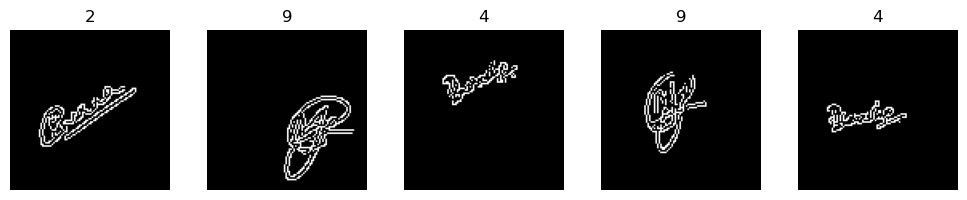

In [5]:
# Edge Detection and Thresholding
def apply_edge_detection_and_thresholding(images):
    processed_images = []
    for img in images:
        if img.dtype != 'uint8':
            img = img.astype('uint8')
        edges = cv2.Canny(img, 100, 200)
        _, thresh = cv2.threshold(edges, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        processed_images.append(thresh)
    return processed_images

processed_images = apply_edge_detection_and_thresholding(combined_images)

# Resize images
def resize_images(images, size=(100, 100)):
    resized_images = []
    for img in images:
        resized = cv2.resize(img, size)
        resized_images.append(resized)
    return resized_images

final_images = resize_images(processed_images)

# Selecting 5 final images and their labels
selected_final_indices = random.sample(range(len(final_images)), 5)
selected_final_images = [final_images[i] for i in selected_final_indices]
selected_final_labels = [combined_labels[i] for i in selected_final_indices]

# Displaying 5 random final images
display_images(selected_final_images, selected_final_labels)

# Training Model

In [6]:
# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(final_images, combined_labels, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    shuffle=True, 
                                                    stratify=combined_labels)
# Normalize and reshape data for CNN
X_train = np.array(X_train) / 255.0
X_test = np.array(X_test) / 255.0
X_train = X_train.reshape((-1, 100, 100, 1))
X_test = X_test.reshape((-1, 100, 100, 1))

# Label encoding
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Save the label encoder
joblib.dump(label_encoder, 'label_encoder.pkl')

['label_encoder.pkl']

In [7]:
# CNN model 1 architecture
model_1 = Sequential()
model_1.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(100,100,1)))
model_1.add(MaxPooling2D())
model_1.add(Conv2D(32, (3,3), 1, activation='relu'))
model_1.add(MaxPooling2D())
model_1.add(Conv2D(16, (3,3), 1, activation='relu'))
model_1.add(MaxPooling2D())
model_1.add(Flatten())
model_1.add(Dense(64, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(len(set(combined_labels)), activation='sigmoid'))

model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_1 = model_1.fit(X_train, y_train_encoded, epochs=20, validation_data=(X_test, y_test_encoded))

Epoch 1/20
96/96 [==============================] - 3s 27ms/step - loss: 1.7082 - accuracy: 0.3770 - val_loss: 1.0505 - val_accuracy: 0.6888
Epoch 2/20
96/96 [==============================] - 3s 27ms/step - loss: 0.8745 - accuracy: 0.6966 - val_loss: 0.5016 - val_accuracy: 0.8307
Epoch 3/20
96/96 [==============================] - 3s 26ms/step - loss: 0.5573 - accuracy: 0.8053 - val_loss: 0.2999 - val_accuracy: 0.9180
Epoch 4/20
96/96 [==============================] - 3s 29ms/step - loss: 0.4001 - accuracy: 0.8587 - val_loss: 0.2598 - val_accuracy: 0.9167
Epoch 5/20
96/96 [==============================] - 3s 27ms/step - loss: 0.2974 - accuracy: 0.8962 - val_loss: 0.1790 - val_accuracy: 0.9531
Epoch 6/20
96/96 [==============================] - 3s 29ms/step - loss: 0.2051 - accuracy: 0.9248 - val_loss: 0.1645 - val_accuracy: 0.9492
Epoch 7/20
96/96 [==============================] - 3s 28ms/step - loss: 0.2092 - accuracy: 0.9274 - val_loss: 0.1581 - val_accuracy: 0.9531
Epoch 8/20
96

In [8]:
# CNN model 2 architecture
model_2 = Sequential()
model_2.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(100,100,1)))
model_2.add(MaxPooling2D())
model_2.add(Conv2D(32, (3,3), 1, activation='relu'))
model_2.add(MaxPooling2D())
model_2.add(Conv2D(16, (3,3), 1, activation='relu'))
model_2.add(MaxPooling2D())
model_2.add(Flatten())
model_2.add(Dense(128, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(len(set(combined_labels)), activation='sigmoid'))

model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_2 = model_2.fit(X_train, y_train_encoded, epochs=20, validation_data=(X_test, y_test_encoded))

Epoch 1/20
96/96 [==============================] - 3s 27ms/step - loss: 1.5810 - accuracy: 0.4495 - val_loss: 0.9310 - val_accuracy: 0.6719
Epoch 2/20
96/96 [==============================] - 3s 28ms/step - loss: 0.7442 - accuracy: 0.7474 - val_loss: 0.3984 - val_accuracy: 0.8893
Epoch 3/20
96/96 [==============================] - 3s 26ms/step - loss: 0.4438 - accuracy: 0.8447 - val_loss: 0.2616 - val_accuracy: 0.9154
Epoch 4/20
96/96 [==============================] - 3s 26ms/step - loss: 0.2946 - accuracy: 0.8981 - val_loss: 0.2034 - val_accuracy: 0.9375
Epoch 5/20
96/96 [==============================] - 3s 26ms/step - loss: 0.2112 - accuracy: 0.9255 - val_loss: 0.1632 - val_accuracy: 0.9466
Epoch 6/20
96/96 [==============================] - 3s 27ms/step - loss: 0.1449 - accuracy: 0.9518 - val_loss: 0.0994 - val_accuracy: 0.9714
Epoch 7/20
96/96 [==============================] - 3s 27ms/step - loss: 0.1290 - accuracy: 0.9574 - val_loss: 0.1068 - val_accuracy: 0.9674
Epoch 8/20
96

In [9]:
# CNN model 3 architecture
model_3 = Sequential()
model_3.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(100,100,1)))
model_3.add(MaxPooling2D())
model_3.add(Conv2D(32, (3,3), 1, activation='relu'))
model_3.add(MaxPooling2D())
model_3.add(Conv2D(16, (3,3), 1, activation='relu'))
model_3.add(MaxPooling2D())
model_3.add(Flatten())
model_3.add(Dense(256, activation='relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(len(set(combined_labels)), activation='sigmoid'))

model_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_3 = model_3.fit(X_train, y_train_encoded, epochs=20, validation_data=(X_test, y_test_encoded))

Epoch 1/20
96/96 [==============================] - 3s 29ms/step - loss: 1.4439 - accuracy: 0.5026 - val_loss: 0.7116 - val_accuracy: 0.7656
Epoch 2/20
96/96 [==============================] - 3s 28ms/step - loss: 0.5476 - accuracy: 0.8167 - val_loss: 0.3060 - val_accuracy: 0.8958
Epoch 3/20
96/96 [==============================] - 3s 28ms/step - loss: 0.3093 - accuracy: 0.8932 - val_loss: 0.2233 - val_accuracy: 0.9336
Epoch 4/20
96/96 [==============================] - 3s 29ms/step - loss: 0.1840 - accuracy: 0.9378 - val_loss: 0.1749 - val_accuracy: 0.9427
Epoch 5/20
96/96 [==============================] - 3s 28ms/step - loss: 0.1073 - accuracy: 0.9639 - val_loss: 0.1099 - val_accuracy: 0.9609
Epoch 6/20
96/96 [==============================] - 3s 29ms/step - loss: 0.0860 - accuracy: 0.9727 - val_loss: 0.1029 - val_accuracy: 0.9714
Epoch 7/20
96/96 [==============================] - 3s 27ms/step - loss: 0.0567 - accuracy: 0.9811 - val_loss: 0.0897 - val_accuracy: 0.9727
Epoch 8/20
96

In [10]:
# CNN model 4 architecture
model_4 = Sequential()
model_4.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(100,100,1)))
model_4.add(MaxPooling2D())
model_4.add(Conv2D(32, (3,3), 1, activation='relu'))
model_4.add(MaxPooling2D())
model_4.add(Conv2D(16, (3,3), 1, activation='relu'))
model_4.add(MaxPooling2D())
model_4.add(Flatten())
model_4.add(Dense(512, activation='relu'))
model_4.add(Dropout(0.5))
model_4.add(Dense(len(set(combined_labels)), activation='sigmoid'))

model_4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_4 = model_4.fit(X_train, y_train_encoded, epochs=20, validation_data=(X_test, y_test_encoded))

Epoch 1/20
96/96 [==============================] - 3s 32ms/step - loss: 1.3728 - accuracy: 0.5189 - val_loss: 0.6835 - val_accuracy: 0.7969
Epoch 2/20
96/96 [==============================] - 3s 29ms/step - loss: 0.4673 - accuracy: 0.8444 - val_loss: 0.3213 - val_accuracy: 0.8997
Epoch 3/20
96/96 [==============================] - 3s 29ms/step - loss: 0.2032 - accuracy: 0.9316 - val_loss: 0.2125 - val_accuracy: 0.9440
Epoch 4/20
96/96 [==============================] - 3s 30ms/step - loss: 0.1204 - accuracy: 0.9561 - val_loss: 0.1320 - val_accuracy: 0.9492
Epoch 5/20
96/96 [==============================] - 3s 30ms/step - loss: 0.0663 - accuracy: 0.9795 - val_loss: 0.0911 - val_accuracy: 0.9727
Epoch 6/20
96/96 [==============================] - 3s 29ms/step - loss: 0.0389 - accuracy: 0.9876 - val_loss: 0.1964 - val_accuracy: 0.9505
Epoch 7/20
96/96 [==============================] - 3s 29ms/step - loss: 0.0413 - accuracy: 0.9860 - val_loss: 0.1247 - val_accuracy: 0.9727
Epoch 8/20
96

# Evaluating Metrics

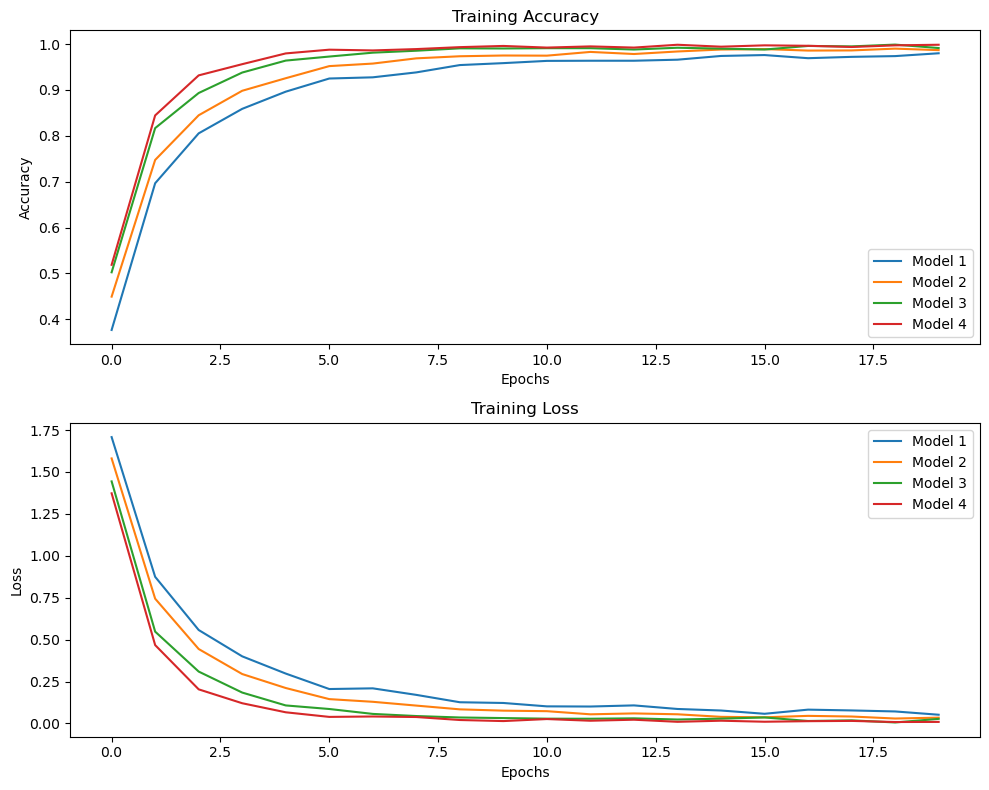

In [11]:
history_objects = [history_1, history_2, history_3, history_4]

# Metrics to plot
metrics = ['accuracy', 'loss'] 

# Creating subplots
fig, axes = plt.subplots(nrows=len(metrics), ncols=1, figsize=(10, 8))

for i, metric in enumerate(metrics):
    for j, history in enumerate(history_objects):
        # Plotting the metric for each model
        axes[i].plot(history.history[metric], label=f'Model {j+1}')
    
    axes[i].set_title(f'Training {metric.capitalize()}')
    axes[i].set_xlabel('Epochs')
    axes[i].set_ylabel(metric.capitalize())
    axes[i].legend()

plt.tight_layout()
plt.show()

In [12]:
from sklearn.metrics import classification_report

y_pred_1 = model_1.predict(X_test)
y_pred_classes_1 = np.argmax(y_pred_1, axis=1)

print("Classification Report for CNN Model 1")
print(classification_report(y_test_encoded, y_pred_classes_1))

y_pred_2 = model_2.predict(X_test)
y_pred_classes_2 = np.argmax(y_pred_2, axis=1)

print("Classification Report for CNN Model 2")
print(classification_report(y_test_encoded, y_pred_classes_2))

y_pred_3 = model_3.predict(X_test)
y_pred_classes_3 = np.argmax(y_pred_3, axis=1)

print("Classification Report for CNN Model 3")
print(classification_report(y_test_encoded, y_pred_classes_3))

y_pred_4 = model_4.predict(X_test)
y_pred_classes_4 = np.argmax(y_pred_4, axis=1)

print("Classification Report for CNN Model 4")
print(classification_report(y_test_encoded, y_pred_classes_4))

24/24 [==============================] - 0s 9ms/step
Classification Report for CNN Model 1
              precision    recall  f1-score   support

           0       0.94      0.99      0.96        96
           1       1.00      0.98      0.99        48
           2       0.98      0.98      0.98        96
           3       0.96      0.99      0.97        96
           4       0.99      1.00      0.99        96
           5       0.95      0.94      0.94        96
           6       0.98      0.90      0.93        48
           7       0.96      0.98      0.97        96
           8       0.99      0.94      0.96        96

    accuracy                           0.97       768
   macro avg       0.97      0.97      0.97       768
weighted avg       0.97      0.97      0.97       768

24/24 [==============================] - 0s 9ms/step
Classification Report for CNN Model 2
              precision    recall  f1-score   support

           0       0.96      0.97      0.96        96
    

In [13]:
y_train_pred_1 = model_1.predict(X_train)
y_train_pred_classes_1 = np.argmax(y_train_pred_1, axis=1)

print('Classification Tree on Training: CNN Model 1')
print(classification_report(y_train_encoded, y_train_pred_classes_1))

y_train_pred_2 = model_2.predict(X_train)
y_train_pred_classes_2 = np.argmax(y_train_pred_2, axis=1)

print('Classification Tree on Training: CNN Model 2')
print(classification_report(y_train_encoded, y_train_pred_classes_2))

y_train_pred_3 = model_3.predict(X_train)
y_train_pred_classes_3 = np.argmax(y_train_pred_3, axis=1)

print('Classification Tree on Training: CNN Model 3')
print(classification_report(y_train_encoded, y_train_pred_classes_3))

y_train_pred_4 = model_4.predict(X_train)
y_train_pred_classes_4 = np.argmax(y_train_pred_4, axis=1)

print('Classification Tree on Training: CNN Model 4')
print(classification_report(y_train_encoded, y_train_pred_classes_4))

96/96 [==============================] - 1s 8ms/step
Classification Tree on Training: CNN Model 1
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       384
           1       0.99      1.00      1.00       192
           2       1.00      1.00      1.00       384
           3       1.00      1.00      1.00       384
           4       0.99      1.00      0.99       384
           5       0.99      0.99      0.99       384
           6       1.00      1.00      1.00       192
           7       1.00      1.00      1.00       384
           8       1.00      0.98      0.99       384

    accuracy                           1.00      3072
   macro avg       1.00      1.00      1.00      3072
weighted avg       1.00      1.00      1.00      3072

96/96 [==============================] - 1s 8ms/step
Classification Tree on Training: CNN Model 2
              precision    recall  f1-score   support

           0       1.00      0.99      1.00 

In [14]:
# Save the best model
model_3.save('signature_verification_model.keras')

# Train on Entire Dataset and Save Model

In [35]:
# Combine the entire dataset
X = np.array(final_images) / 255.0
X = X.reshape((-1, 100, 100, 1))
y = label_encoder.transform(combined_labels)
joblib.dump(label_encoder, 'label_encoder_full.pkl')

['label_encoder_full.pkl']

In [ ]:
# CNN model 3 architecture
model_3 = Sequential()
model_3.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(100, 100, 1)))
model_3.add(MaxPooling2D())
model_3.add(Conv2D(32, (3, 3), 1, activation='relu'))
model_3.add(MaxPooling2D())
model_3.add(Conv2D(16, (3, 3), 1, activation='relu'))
model_3.add(MaxPooling2D())
model_3.add(Flatten())
model_3.add(Dense(256, activation='relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(len(set(combined_labels)), activation='sigmoid'))

model_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model on the entire dataset
history_3 = model_3.fit(X, y, epochs=20, shuffle=True)

In [34]:
# Save the best model trained on full dataset
model_3.save('signature_verification_model_full.keras')

In [36]:
# Classification Report for Model on Entire Dataset
y_pred = model_1.predict(X)
y_pred_classes = np.argmax(y_pred, axis=1)

print("Classification Report for CNN Model on Entire Dataset")
print(classification_report(y, y_pred_classes))

120/120 [==============================] - 1s 7ms/step
Classification Report for CNN Model on Entire Dataset
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       480
           1       1.00      1.00      1.00       240
           2       1.00      1.00      1.00       480
           3       0.99      1.00      0.99       480
           4       0.99      1.00      0.99       480
           5       0.98      0.98      0.98       480
           6       1.00      0.98      0.99       240
           7       0.99      1.00      0.99       480
           8       1.00      0.97      0.99       480

    accuracy                           0.99      3840
   macro avg       0.99      0.99      0.99      3840
weighted avg       0.99      0.99      0.99      3840

